# General problem definition

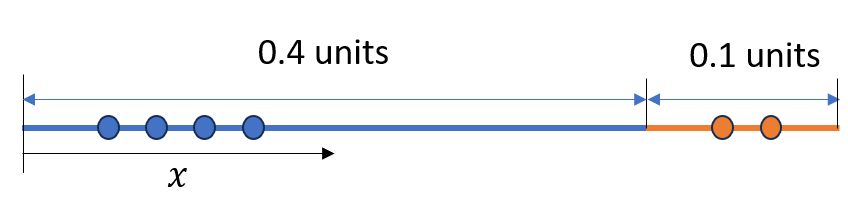

Consider a 1D heat conduction problem
$$ - \frac{\partial}{\partial x} k(x,T,\mu)\frac{\partial T}{\partial x} = q(x)$$
where the conductivity is a function of temperature. 

As an example, we can use
$$k(x,T,\mu)=k(x,\mu)$$
Hence, we are solving:
$$- \frac{\partial}{\partial x}k(x,\mu) \frac{\partial T}{\partial x} = q(x)
$$

Here the function $k(x,\mu)$ can be defined using the piecewise function notation

$$
k(x,\mu) = 
\begin{cases} 
1+\mu & \text{if } 0 \leq x \leq 0.4  \\
10|\sin(\mu)| & \text{if } 0.4\leq x \leq 0.5
\end{cases}
$$

Where as for the nonlinear problem we define $k(x,\mu)$ in the following way:

$$
k(x,\mu) = 
\begin{cases} 
1.05*mu + 2150/(T-73.15) & \text{if } 0 \leq x \leq 0.4  \\
7.51 + 2.09\times10^{-2}T - 1.45\times10^{-5}T^2 + 7.67\times10^{-9}T^3 & \text{if } 0.4\leq x \leq 0.5
\end{cases}
$$ 

Here $\mu\in[0,10]$

**Boundary conditions**:
- Reflective at $x=0$: $\quad \left.\tfrac{\partial T}{\partial x}\right|_{x=0} = 0$

- Imposed temperature (Dirichlet bc) at $x=L=0.5$: $\quad T(L)=T_{bc}=573.15K$

# Finding the weak form of the PDE

To derive the weak form of the given PDE, let's follow these steps:

1) Multiply the PDE by a test function $ v(x) $ and integrate over the domain $ \Omega $:

$$
-\int_{\Omega} v(x) \frac{\partial}{\partial x} \left( k(x,T,\mu) \frac{\partial T}{\partial x} \right) \, dx = \int_{\Omega} v(x) q(x) \, dx
$$

2) Apply integration by parts:

$$
\int_{\Omega} v(x) \frac{\partial}{\partial x} \left( k(x,T,\mu) \frac{\partial T}{\partial x} \right) \, dx = v(x) \left( k(x,T,\mu) \frac{\partial T}{\partial x} \right) \Bigg|_{\partial \Omega} - \int_{\Omega} \frac{\partial v}{\partial x} k(x,T,\mu) \frac{\partial T}{\partial x} \, dx
$$

On the boundary $ \Gamma_D $, the test function $ v(x) $ is zero due to the Dirichlet condition. The boundary term, therefore, only contributes on $ \Gamma_N $:

$$
v(x) \left( k(x,T,\mu) \frac{\partial T}{\partial x} \right) \Bigg|_{\Gamma_N} = v(x) g(x) \Bigg|_{\Gamma_N}
$$

3) The weak form then becomes:

$$
\int_{\Omega} \frac{\partial v}{\partial x} k(x,T,\mu) \frac{\partial T}{\partial x} \, dx - v(x) g(x) \Bigg|_{\Gamma_N} = \int_{\Omega} v(x) q(x) \, dx
$$

This gives us the weak form for the PDE with both Neumann and Dirichlet boundary conditions. For this case, $v(x) g(x) \Bigg|_{\Gamma_N} = 0$ 

$$
\int_{\Omega} \frac{\partial v}{\partial x} k(x,T,\mu) \frac{\partial T}{\partial x} \, dx - \int_{\Omega} v(x) q(x) \, dx = 0
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
import random
from scipy import sparse
from scipy.sparse import linalg
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.optimize import minimize
from scipy.optimize import nnls
from fnnls import fnnls
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression #nnls
import fnnlsEigen as fe #nnls
import cvxpy as cp

ModuleNotFoundError: No module named 'fnnls'

In [ ]:
#!pip install fnnlsEigen
#!pip install cvxpy
#!pip install cylp
!pip install cvxpy[SCS]
#,GUROBI,MOSEK,PDLP,SCIP,XPRESS]


# class for data (geometry, material property, mesh)

In [ ]:
class mydata:
    
    def __init__(self, n_ref, zone_widths, mu):
        """
        Initialize the mesh data for a given domain with specified refinement and zone widths.

        Parameters:
        - n_ref: List of refinement levels for each zone
        - zone_widths: List of widths for each zone in the domain
        - mu: Parameter value
        """

        # Check if the input lists have the same length
        if len(zone_widths) != len(n_ref):
            raise ValueError("dx and nref should have the same length")
        
        self.n_zones = len(zone_widths)

        # Compute the width of each cell in the mesh
        dx = np.repeat(zone_widths / n_ref, n_ref)

        # Compute the x-coordinates of the nodes in the mesh
        x = np.zeros(len(dx) + 1)
        for i in range(len(dx)):
            x[i + 1] = x[i] + dx[i]

        # Define which material each cell belongs to
        cell2mat = np.repeat(np.arange(len(zone_widths)), n_ref)

        # Store mesh information
        self.n_cells = len(dx)
        self.n_nodes = self.n_cells + 1
        
        # Create nodal connectivity for the continuous Finite Element Method (cFEM)
        self.connectivity()
        
        # Store additional data
        self.dx = np.copy(dx)
        self.x = np.copy(x)
        self.cell2mat = np.copy(cell2mat)
        
        # Store parameter value
        self.mu = mu
        
    def connectivity(self):
        """
        Define nodal connectivity for each cell in the mesh.
        """

        # Initialize the connectivity array
        self.gn = np.zeros((self.n_cells, 2), dtype=int)

        # Loop over all cells to define their nodal connectivity
        for i in range(self.n_cells):
            # For each cell, define the left and right nodes
            self.gn[i, 0] = i
            self.gn[i, 1] = i + 1


# class for FEM solver

In [ ]:
class FEM_solver:

    def __init__(self, data, quad_degree):
        """
        Initialize the class with given data and quadrature degree.

        Parameters:
        - data: Provided data object containing mesh information
        - quad_degree: Quadrature degree for numerical integration
        """

        # Store the provided data
        self.data = data

        # Store some shortcuts for frequently accessed data attributes
        self.n_cells = data.n_cells
        self.n_nodes = data.n_nodes
        self.dx = np.copy(data.dx)

        # Compute the continuous Finite Element (cFEM) basis functions
        self.basis()

        # Compute the elemental matrices for the given quadrature degree
        self.basis_q(quad_degree)


    def basis(self):
        """
        Define the basis functions and their derivatives for the interval [-1, 1].
        """

        # List of basis functions defined on the interval [-1, 1] in counter-clockwise ordering
        self.b = []
        self.b.append(lambda u: (1 - u) / 2)
        self.b.append(lambda u: (1 + u) / 2)

        # Derivatives of the basis functions with respect to the local coordinate 'u'
        self.dbdx = []
        self.dbdx.append(lambda u: -0.5)
        self.dbdx.append(lambda u:  0.5)


    def basis_q(self, quad_degree, verbose=False):
        """
        Compute the basis functions and their derivatives at the quadrature points.

        Parameters:
        - quad_degree: Degree of the Gauss-Legendre quadrature
        - verbose: Flag to control print output (default is False)
        """

        # Use Gauss-Legendre quadrature to get the quadrature points 'xq' and weights 'wq' for the given degree
        [xq, self.wq] = np.polynomial.legendre.leggauss(quad_degree)

        # Initialize arrays to store values of basis functions and their derivatives at the quadrature points
        self.bq  = np.zeros((len(xq), len(self.b)))
        self.dbq = np.zeros_like(self.bq)

        # Evaluate the basis functions and their derivatives at each quadrature point
        for q, uq in enumerate(xq):
            for i, (fi, fxi) in enumerate(zip(self.b, self.dbdx)):
                self.bq[q, i] = fi(uq)
                self.dbq[q, i] = fxi(uq)

        
    def handle_boundary_conditions(self, bc):
        """
        Identify nodes corresponding to Dirichlet boundary conditions and their values.

        Parameters:
        - bc: Dictionary containing boundary conditions. 
              Expected keys are 'xmin' and 'xmax', with each having subkeys 'type' and 'value'.

        Returns:
        - dir_nodes: List of node indices that have Dirichlet boundary conditions
        - T_dir: List of boundary condition values for the corresponding nodes in dir_nodes
        """

        # Lists to store nodes with Dirichlet boundary conditions and their corresponding values
        dir_nodes = []
        T_dir = []

        # Check the boundary condition at the left end ('xmin') of the domain
        if bc['xmin']['type'] != 'refl':
            dir_nodes.append(0)
            T_dir.append(bc['xmin']['value'])

        # Check the boundary condition at the right end ('xmax') of the domain
        if bc['xmax']['type'] != 'refl':
            dir_nodes.append(self.n_nodes - 1)
            T_dir.append(bc['xmax']['value'])

        return np.asarray(dir_nodes), T_dir

    
    def dirichlet_bc(self, T_dir, dir_nodes, elem_glob_nodes):
        """
        Assign Dirichlet boundary condition values to the local degrees of freedom of an element.

        Parameters:
        - T_dir: List of boundary condition values
        - dir_nodes: List of node indices that have Dirichlet boundary conditions
        - elem_glob_nodes: Global node numbers associated with the current element

        Returns:
        - z: Array containing the Dirichlet boundary condition values for the local DOFs of the element
        """

        # Initialize an array to store the Dirichlet boundary condition values for the local DOFs
        z = np.zeros(len(elem_glob_nodes)).astype(int)

        # Identify which nodes of the current element have Dirichlet boundary conditions
        mask = np.isin(elem_glob_nodes, dir_nodes)

        # Assign the Dirichlet boundary condition values to the local DOFs
        for idx in np.where(mask)[0]:
            dir_index = np.searchsorted(dir_nodes, elem_glob_nodes[idx])
            z[idx] = T_dir[dir_index]

        return z

              
    def get_glob_node_equation_id(self, dir_nodes):
        """
        Assign a global equation number to each degree of freedom (DOF) of the mesh.
        For DOFs corresponding to Dirichlet boundary conditions, the equation number is set to 0.
        Only non-zero equation numbers will be solved.

        Parameters:
        - dir_nodes: Nodes corresponding to Dirichlet boundary conditions

        Returns:
        - node_eqnId: Array of global equation numbers for each node in the mesh
        """

        # Initialize an array to store global equation numbers for each node
        node_eqnId = np.zeros(self.n_nodes).astype(int)

        # Get a list of unique global nodes in the mesh
        glob_nodes = np.unique(self.data.gn)

        # Loop over all nodes in the mesh
        for i in range(len(node_eqnId)):
            # Check if the current global node corresponds to a Dirichlet boundary condition
            if np.isin(glob_nodes[i], dir_nodes):
                # Set equation number to 0 for nodes with Dirichlet boundary conditions
                node_eqnId[i] = 0
            else:
                # Assign the next available equation number to the current node
                node_eqnId[i] = int(max(node_eqnId)) + 1

        return node_eqnId

        
    def eval_at_quadrature_points(self, T_prev, elem_glob_nodes):
        """
        Evaluate temperature and its derivative at the quadrature points using the FE basis functions.

        Parameters:
        - T_prev: Previous temperature field
        - elem_glob_nodes: Global node numbers associated with the current element

        Returns:
        - T_prev_q: Temperature values at the quadrature points
        - dT_prev_q: Temperature derivative values at the quadrature points
        """

        # Initialize arrays to store temperature and its derivative at the quadrature points
        T_prev_q = np.zeros(len(self.bq))
        dT_prev_q = np.zeros(len(self.bq))

        # Loop over all nodes associated with the current element
        for i, ind_i in enumerate(elem_glob_nodes):
            # Evaluate temperature at the quadrature points using the FE basis functions
            T_prev_q += self.bq[:, i] * T_prev[ind_i]

            # Evaluate temperature derivative at the quadrature points using the FE basis function derivatives
            dT_prev_q += self.dbq[:, i] * T_prev[ind_i]

        return T_prev_q, dT_prev_q
 
    
    def element_matrices(self, cond_arr, qext_arr, T_prev, iel, node_eqnId):
        """
        Compute the element matrices and vectors for a given temperature field.

        Parameters:
        - cond_arr: Conductivity array
        - qext_arr: External heat source array
        - T_prev: Previous temperature field
        - iel: Current element index
        - node_eqnId: Node equation IDs

        Returns:
        - Ke_: Element stiffness matrix
        - Je_: Element Jacobian matrix
        - qe_: Element source vector
        - Le_: Element matrix
        """

        # Retrieve material and geometric data for the current element
        mu = self.data.mu
        imat = self.data.cell2mat[iel]
        k, dkdT = cond_arr[imat]
        qext = qext_arr[imat]

        # Evaluate temperature and its derivative at quadrature points
        T_prev_q, dT_prev_q = self.eval_at_quadrature_points(T_prev, self.data.gn[iel, :])
        cond_q = k(T_prev_q, mu)
        dcond_q = dkdT(T_prev_q, mu)
        qext_q = qext(T_prev_q, mu)

        # Get global node numbers associated with the current element
        elem_glob_nodes = self.data.gn[iel, :]

        # Initialize element matrices and vectors
        n = len(elem_glob_nodes)
        Ke_ = np.zeros((n, n))
        Je_ = np.zeros((n, n))
        qe_ = np.zeros(n)
        Le_ = np.zeros((n, self.n_nodes))

        # Fill Le_ matrix using the global node numbers
        for i, ind_i in enumerate(elem_glob_nodes):
            Le_[i, ind_i] = 1

        # Compute the element matrices Ke_ and Je_ using nested loops
        for i in range(n):
            # Compute source vector for the current node
            qe_[i] = (self.dx[iel] / 2) * np.dot(self.wq * self.bq[:, i], qext_q)

            for j in range(n):
                
                # Compute stiffness matrix entry for the current pair of nodes
                Ke_[i, j] = 2 / self.dx[iel] * np.dot(self.wq * self.dbq[:, i], cond_q * self.dbq[:, j])

                # Compute Jacobian matrix entry for the current pair of nodes
                Je_[i, j] = 2 / self.dx[iel] * np.dot(self.wq * self.dbq[:, i], dcond_q * self.bq[:, j] * dT_prev_q)

        return Ke_, Je_, qe_, Le_

       
    def eval_resJac(self, cond_arr, qext_arr, bc, T_prev, node_eqnId):
        """
        Evaluate the residual and Jacobian matrix for a given temperature field.

        Parameters:
        - cond_arr: Conductivity array
        - qext_arr: External heat source array
        - bc: Boundary conditions
        - T_prev: Previous temperature field
        - node_eqnId: Node equation IDs

        Returns:
        - K + J: Sum of stiffness matrix and Jacobian
        - res: Residual vector
        - Le: List of element matrices
        - Ke: List of element stiffness matrices
        - rhs_e: List of right-hand side element vectors
        """

        # Handle boundary conditions and get Dirichlet nodes and their temperature values
        dir_nodes, T_dir = self.handle_boundary_conditions(bc)

        # Create a mask for non-zero node equation IDs
        mask = node_eqnId != 0

        # Initialize matrices and vectors for global system
        K = sparse.lil_matrix((max(node_eqnId), max(node_eqnId)))
        J = sparse.lil_matrix((max(node_eqnId), max(node_eqnId)))
        rhs = np.zeros(max(node_eqnId))

        # Lists to store element matrices and vectors
        Le = []
        Ke = []
        rhs_e = []

        # Loop over all elements (cells) in the domain
        for iel in range(self.n_cells):
            # Get the global node numbers associated with this element
            elem_glob_nodes = self.data.gn[iel, :]

            # Get the equation IDs associated with these nodes
            elem_glob_node_eqnId = node_eqnId[elem_glob_nodes]

            # Find nodes of the element that are not associated with Dirichlet boundaries
            nonzero_mask = elem_glob_node_eqnId != 0
            elem_glob_node_nonzero_eqnId = elem_glob_node_eqnId[nonzero_mask]
            elem_local_node_nonzero_eqnId = np.nonzero(nonzero_mask)[0]

            # Compute the element matrices for the current element
            Ke_, Je_, qe_, Le_ = self.element_matrices(cond_arr, qext_arr, T_prev, iel, node_eqnId)

            # Mapping from local to global DOFs
            I_index, J_index = np.meshgrid(elem_glob_node_nonzero_eqnId-1, elem_glob_node_nonzero_eqnId-1)
            i_index, j_index = np.meshgrid(elem_local_node_nonzero_eqnId, elem_local_node_nonzero_eqnId)

            # Assemble the global matrices
            K[I_index, J_index] += Ke_[i_index, j_index]
            J[I_index, J_index] += Je_[i_index, j_index]

            # Check and handle Dirichlet boundary conditions
            if np.isin(0, elem_glob_node_eqnId):
                elem_dof_values = self.dirichlet_bc(T_dir, dir_nodes, elem_glob_nodes)
                fe = Ke_ @ elem_dof_values.reshape(-1, 1)
            else:
                fe = np.zeros((len(elem_glob_nodes), 1))

            # Compute the right-hand side for the element
            rhs_e_ = qe_[elem_local_node_nonzero_eqnId] - fe[elem_local_node_nonzero_eqnId].flatten()
            rhs[elem_glob_node_nonzero_eqnId-1] += rhs_e_

            # Append the element matrices and vectors to the lists
            rhs_e.append(rhs_e_)
            Le.append(Le_[elem_local_node_nonzero_eqnId][:,mask])
            Ke.append(Ke_[i_index, j_index])

        # Compute the global residual
        res = K @ T_prev[mask] - rhs

        return K + J, res, Le, Ke, rhs_e

    
    def solve_system(self, cond_arr, qext_arr, bc, T_init, tol=1e-5, max_iter=300):
        """
        Solve the nonlinear system using a Newton-Raphson method.

        Parameters:
        - cond_arr: Conductivity array
        - qext_arr: External heat source array
        - bc: Dictionary containing boundary conditions
        - T_init: Initial guess for the temperature field
        - tol: Tolerance for convergence (default is 1e-5)
        - max_iter: Maximum number of iterations (default is 300)

        Returns:
        - T: Solved temperature field
        - Le: List of element matrices
        - Ke: List of element stiffness matrices
        - rhs_e: Right-hand side element vectors
        - mask: Mask indicating which nodes have non-zero equation IDs
        - T_dir: Temperature values at the Dirichlet boundary nodes
        """

        # Handle boundary conditions and get node equation IDs
        dir_nodes, T_dir = self.handle_boundary_conditions(bc)
        node_eqnId = self.get_glob_node_equation_id(dir_nodes)

        # Create a mask for nodes that do not have a Dirichlet boundary condition
        mask = node_eqnId != 0

        # Update initial temperature values for Dirichlet boundary nodes
        T_init[~mask] = T_dir

        # Sanity checks
        if len(bc) != 2:
            raise ValueError('bc dictionary must have 2 keys')
        if self.data.n_zones != len(cond_arr):
            raise ValueError('len(cond_arr) /= n_zones')
        if self.data.n_zones != len(qext_arr):
            raise ValueError('len(qext_arr) /= n_zones')

        # Copy the initial temperature field
        T = np.copy(T_init)

        # Evaluate the Jacobian, residual, and other relevant matrices/vectors
        Jac, res, Le, Ke, rhs_e = self.eval_resJac(cond_arr, qext_arr, bc, T, node_eqnId)

        # Compute the initial norm of the residual
        norm_ = np.linalg.norm(res)
        print('initial residual =', norm_, "\n")

        it = 0

        # Start the Newton-Raphson iterative process
        while (it < max_iter) and not(norm_ < tol):
            # Solve for the temperature increment (delta) using the current Jacobian and residual
            delta = linalg.spsolve(Jac.tocsc(), -res)

            # Update the temperature field (excluding Dirichlet) using the computed increment
            T[mask] += delta

            # Re-evaluate the Jacobian, residual, and other relevant matrices/vectors
            Jac, res, Le, Ke, rhs_e = self.eval_resJac(cond_arr, qext_arr, bc, T, node_eqnId)

            # Compute the current norm of the residual
            norm_ = np.linalg.norm(res)

            # Print current iteration details
            print("iter {}, NL residual={}, delta={}".format(it, norm_, np.max(delta)))

            # Check convergence
            if norm_ < tol:
                print('Convergence !!!')
            else:
                if it == max_iter - 1:
                    print('\nWARNING: nonlinear solution has not converged')

            # Increment the iteration counter
            it += 1

        return T.reshape(-1, 1), Le, Ke, rhs_e, mask, T_dir


## Generate Snapshots from multiple runs with varying $\mu$

##### Paramters

In [ ]:
random.seed(25)
params = np.r_[1.:10.0:0.01]
NL_solutions = []
param_list = []
quad_deg = 5
N_snap = 15 # Training Snapshots

##### For ECSW

In [ ]:
K_mus = []
q_mus = []

##### System Data

In [1]:
width   = np.array([ 0.4, 0.1])
n_ref = np.array([400, 100], dtype=int)
cond_arr = []

NameError: name 'np' is not defined

In [ ]:
## Conductivity array as function of T and parameter

# data T in Kelvin. conductivity in W/m/K
# conductivity functions per zone

tune = 1 # Parameter to tune nonlinearity

cond_arr = []

cond_arr.append( [lambda T,mu: 1.05*mu*tune + 2150/(T-73.15),lambda T,mu: -2150/(T-73.15)**2]  )
cond_arr.append( [lambda T,mu: mu*tune*7.51 + 2.09e-2*T - 1.45e-5*T**2 + 7.67e-9*T**3,\
                  lambda T,mu: 2.09e-2 - 2*1.45e-5*T + 3*7.67e-9*T**2])
    
# cond_arr.append( [lambda T,mu: (1+mu) + tune*T, lambda T,mu: tune] ) #[k, dk/dT]
# cond_arr.append( [lambda T,mu: 10*abs(np.sin(mu)) + 0.*T, lambda T,mu: 0.0*T] )
cond_arr = np.asarray(cond_arr)

    
qext_arr = []
qext_arr.append( lambda T,mu: 35000.0 + 0.*T)
qext_arr.append( lambda T,mu: 0.0 + 0.*T)
qext_arr = np.asarray(qext_arr)

In [ ]:
## Boundary Conditions (in degree Kelvin):
dummy_param = 1
dp = mydata(n_ref, width, dummy_param)

bc = {}

bc_sym={'type':'refl','value':np.nan}
bc_dir={'type':'dirichlet','value':273.15+300.}

bc['xmin']=bc_sym
bc['xmax']=bc_dir

T_init = np.zeros(dp.n_nodes) + 273.15

if bc['xmin']['type']=='dirichlet':
    T_init[0] = bc['xmin']['value']
if bc['xmax']['type']=='dirichlet':
    T_init[-1] = bc['xmax']['value']
    

In [ ]:
for i in range(N_snap):
    
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    d = mydata(n_ref, width,param)
    solver = FEM_solver(d, quad_deg)
    
    # solve
    if i==0:
        NL_solution_p, Le, Ke, rhs_e,_,_ = solver.solve_system(cond_arr, qext_arr, bc, T_init)
        NL_solution_p = NL_solution_p
    else:
        NL_solution_p,_, Ke, rhs_e, mask, T_dir = solver.solve_system(cond_arr, qext_arr, bc, T_init) # Note mask and T_dir are taken out
        NL_solution_p = NL_solution_p 
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    

### Show Snapshots

In [ ]:
plt.figure()

for _,val in enumerate(NL_solutions):
    plt.plot(d.x,val)
    plt.grid(True)
    
plt.show()

In [ ]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

 # ECSW Hyper-reduction

Total virtual work-done should be preserved to the extent possible:
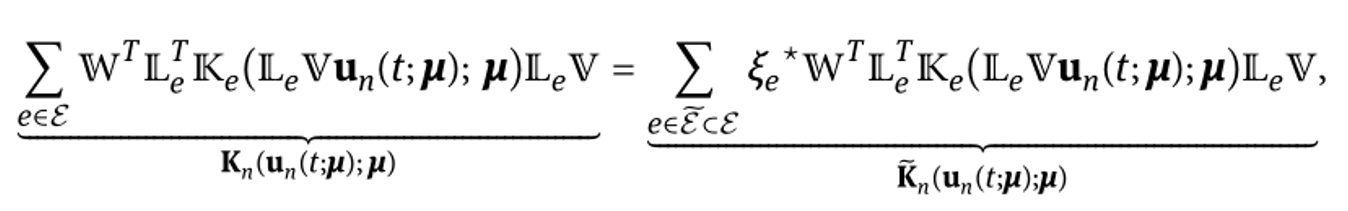


Consider there are multiple snapshots corresponding to different parameter values: $\large \{\mathbf{u}^{s}_{N_h}\} ^{\mathbf{n}_s}_{s=1}$. We can write down the virtual work done for these different cases, in a compact fashion, using the following notation:
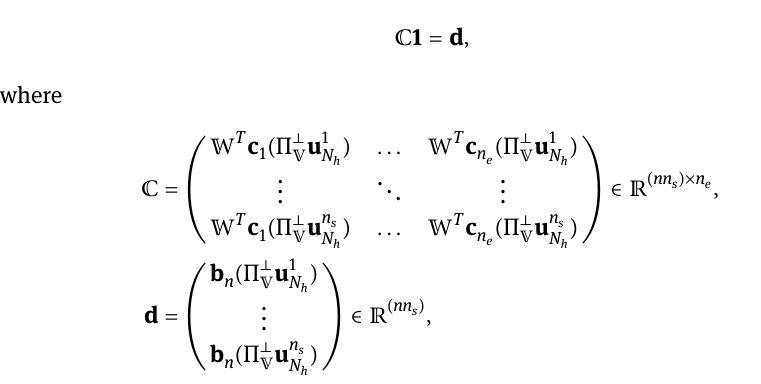

## Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

In [ ]:
# n_sel = 5
# pca = PCA(n_components=n_sel)  # Reduce to 3 components
# pca.fit_transform(NLS)
# S = pca.singular_values_
# V_sel = np.transpose(pca.components_)

In [ ]:
#SVD
n_sel = 8
U, S, Vt = np.linalg.svd(np.transpose(NLS), full_matrices=False)
V_sel = U[:, :n_sel]


In [ ]:
plt.figure(figsize = (6,4))
plt.semilogy(S,'s-')
plt.show()

In [ ]:
plt.figure(figsize=(6,4))

for i in range(n_sel):
    plt.plot(d.x,V_sel[:,i])
plt.grid(True)
plt.show()

P_sel = V_sel[mask,:]@np.transpose(V_sel[mask,:])

## Step-2 Calculate virtual workdone $\mathbf{d}$ corresponding to $s^{th}$ snapshot $\mathbf{u}^{s}_{N_h}\in\mathbb{R}^{N_h\times 1}$:


$$
\mathbf{c}^{s}_e\in\mathbb{R}^{N_h\times 1} := \mathbb{L}_{e}^{T}{\cal K}_e(\mu)\mathbb{L}_{e}\mathbb{\Pi}_{\mathbb{V}}\mathbf{u}^{s}_{N_h}(\mu,x) - \mathbb{L}_{e}^{T}\mathbf{q}^s_e(x)
$$

And
$$
\mathbf{b}^s_n\in\mathbb{R}^{n\times 1} := \sum_{e\in{\cal E}}\mathbb{V}^{T}\mathbf{c}^s_e
$$
This the the total virtual work done in the direction of $n$ column vectors of $\mathbb{V}$

In [ ]:
tic_h_setup_a = time.time()

ncells = d.n_cells
C = np.zeros((n_sel*N_snap,ncells))

for i in range(N_snap):
    for j in range(ncells):
        Ce = np.transpose(V_sel[mask,:])@np.transpose(Le[j])@K_mus[i][j]@Le[j]@P_sel@NL_solutions[i][mask].reshape(-1,1) - np.transpose(V_sel[mask,:])@np.transpose(Le[j])@np.array(q_mus[i][j]).reshape(-1,1)
        C[i*n_sel:(i+1)*n_sel,j] = Ce.flatten()
        
d_vec = C@np.ones((d.n_cells,1))

toc_h_setup_a = time.time()

## Step-3 calculate $\xi^{*}$:

To find a reduced mesh, we want the following:
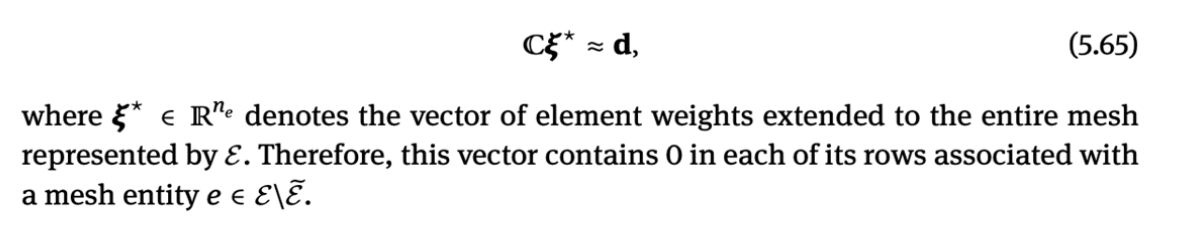

 ### Approach - 1: Non-negative Least Squares (NNLS)

##### Scipy-nnls, fnnls

In [ ]:
# x, rnorm = nnls(C, d_vec.flatten(),maxiter=50)
# x, rnorm = fnnls(C, d_vec.flatten())

# x = list(x+2.0*np.random.rand(len(x))) #test
# plt.stem(x)
# plt.show()
# print(rnorm)

##### Scikit_learn

In [ ]:
# nnls = LinearRegression(positive=True)
# # Fit the model
# nnls.fit(C, d_vec.flatten())
# # Get the coefficients
# x = nnls.coef_
# plt.stem(x)
# plt.show()

##### fnnlsEigen

In [ ]:
tic_h_setup_b = time.time()

x = fe.fnnls(C, d_vec.flatten(), tolerance=1e-11)#, max_iterations=20) 

toc_h_setup_b = time.time()

residual = np.linalg.norm(d_vec.flatten() - np.dot(C, x))/np.linalg.norm(d_vec.flatten())
print(residual)
plt.stem(x)
plt.show()

In [ ]:
print(f"Fraction of total elements active in the ROM: {len(x[x>0])*100/len(x)}%")

 ## Approach - 2: L_1 minimum norm solution

def L1_norm(x):<br>
    return np.linalg.norm(x,ord=1)<br>
bounds = [(0, np.Inf) for _ in range(ncells)]<br>
constr = ({'type':'eq','fun': lambda x: C @ x - d_vec})<br>
x0 = np.linalg.pinv(C) @ d_vec<br>
x0 = np.ones(ncells)<br>
res = minimize(L1_norm, x0, method="SLSQP", constraints=constr, bounds=bounds)<br>
s_L1=res.x

In [ ]:
z = cp.Variable(shape=(500,),nonneg=True)

# Define the objective function (L1 norm of x)
objective = cp.Minimize(cp.norm(z,1))


constraints = [C@z == d_vec.flatten()]

# Formulate the optimization problem
prob = cp.Problem(objective, constraints)


# ECOS and SCS solvers fail to converge before
# the iteration limit. Use CVXOPT instead.

prob.solve(solver=cp.OSQP, verbose=True)

print('Solver status: {}'.format(prob.status))

In [ ]:
# Display the results

print(f'Minimum L1 norm: {prob.value}')

#print(f'Optimal value of x: {x.value}')

print(np.linalg.norm(C@z.value-d_vec.flatten())/np.linalg.norm(d_vec.flatten()))

plt.stem(z.value)
plt.show()
x_=z.value
print(f"Fraction of total elements active in the ROM: {len(x_[x_>0])*100/len(x_)}%")

## LASSO

In [ ]:
# z = cp.Variable(shape=(500,),nonneg=True)
# lambda_reg = 0.1  # Set your lambda value

# # Define the objective function (L1 norm of x)
# objective = cp.Minimize(cp.norm(C @ z - d_vec.flatten(), 'fro')**2 + lambda_reg * cp.norm(z, 1))

# # Formulate the optimization problem
# prob = cp.Problem(objective, constraints)


# # ECOS and SCS solvers fail to converge before
# # the iteration limit. Use CVXOPT instead.

# prob.solve(verbose=True)
# print('Solver status: {}'.format(prob.status))

# Solving a ROM for an unknown $\mu$

In [ ]:
class FEM_solver_rom(FEM_solver):
    
    
    def __init__(self, data, quad_degree):
        """Initialize the reduced-order FEM solver."""
        super().__init__(data, quad_degree)
    
    
    def eval_resJac_rom(self, cond_arr, qext_arr, bc, T_red, xi, V, node_eqnId):
        """
        Evaluate the residual and Jacobian matrices for the reduced-order system.
        """
        print(self.data.mu)
        # Handle boundary conditions
        dir_nodes, T_dir = self.handle_boundary_conditions(bc)

        # Create a mask for nodes with non-zero equation IDs
        mask = node_eqnId != 0

        # Initialize sparse matrices for stiffness (K), Jacobian (J), and rhs
        K = sparse.lil_matrix((max(node_eqnId), max(node_eqnId)))
        J = sparse.lil_matrix((max(node_eqnId), max(node_eqnId)))
        rhs = np.zeros(max(node_eqnId))
        
        # Compute the previous temperature field from the reduced temperature field
        T_prev = V @ T_red.reshape(-1, 1)

        # Loop through all the elements
        for iel in range(self.n_cells):

            # Skip elements with zero importance (xi value)
            if xi[iel] == 0:
                continue

            # Obtain global nodes and their equation IDs for the current element
            elem_glob_nodes = self.data.gn[iel, :]
            elem_glob_node_eqnId = node_eqnId[elem_glob_nodes]

            # Create a mask for non-zero equation IDs and filter the global nodes accordingly
            nonzero_mask = elem_glob_node_eqnId != 0
            elem_glob_node_nonzero_eqnId = elem_glob_node_eqnId[nonzero_mask]
            elem_local_node_nonzero_eqnId = np.nonzero(nonzero_mask)[0]

            # Compute the element matrices for the current element
            Ke_, Je_, qe_, Le_ = self.element_matrices(cond_arr, qext_arr, T_prev, iel, node_eqnId)

            # Define indices for the global and local nodes
            I_index, J_index = np.meshgrid(elem_glob_node_nonzero_eqnId-1, elem_glob_node_nonzero_eqnId-1)
            i_index, j_index = np.meshgrid(elem_local_node_nonzero_eqnId, elem_local_node_nonzero_eqnId)

            # Update the global matrices by adding the weighted element matrices
            K[I_index, J_index] += Ke_[i_index, j_index] * xi[iel]
            J[I_index, J_index] += Je_[i_index, j_index] * xi[iel]

            # Handle Dirichlet boundary conditions
            if np.isin(0, elem_glob_node_eqnId):
                elem_dof_values = self.dirichlet_bc(T_dir, dir_nodes, elem_glob_nodes)
                fe = Ke_ @ elem_dof_values.reshape(-1, 1) # np.zeros((len(elem_glob_nodes), 1))  # 
            else:
                fe = np.zeros((len(elem_glob_nodes), 1))

            # Compute the right-hand side element vector
            rhs_e_ = qe_[elem_local_node_nonzero_eqnId] - fe[elem_local_node_nonzero_eqnId].flatten()

            # Update the global right-hand side vector
            rhs[elem_glob_node_nonzero_eqnId-1] += xi[iel] * rhs_e_

        # Compute the reduced residual using the projection matrix V
        res = np.transpose(V[mask, :]) @ K @ T_prev[mask] - np.transpose(V[mask, :]) @ rhs.reshape(-1, 1)

        # Return the reduced Jacobian and residual
        return np.transpose(V[mask]) @ (K + J) @ V[mask], res


    def solve_reduced_system(self, cond_arr, qext_arr, bc, T_init, xi, V, tol=1e-5, max_iter=300):
        """
        Solve the nonlinear system for the reduced-order model using Newton-Raphson iteration.
        """

        # Handle boundary conditions
        dir_nodes, T_dir = self.handle_boundary_conditions(bc)

        # Obtain global equation IDs for nodes
        node_eqnId = self.get_glob_node_equation_id(dir_nodes)

        # Create a mask for nodes with non-zero equation IDs
        mask = node_eqnId != 0

        # Ensure boundary conditions and material arrays have the correct dimensions
        if len(bc) != 2:
            raise ValueError('bc dictionary must have 2 keys')
        if self.data.n_zones != len(cond_arr):
            raise ValueError('len(cond_arr) /= n_zones')
        if self.data.n_zones != len(qext_arr):
            raise ValueError('len(qext_arr) /= n_zones')

        # Initialize the temperature field
        T = np.copy(T_init)

        # Evaluate the reduced Jacobian and residual for the initial guess
        Jac, res = self.eval_resJac_rom(cond_arr, qext_arr, bc, T, xi, V, node_eqnId)

        # Compute the initial residual norm
        norm_ = np.linalg.norm(res)
        print('initial residual =', norm_, "\n")

        # Initialize iteration counter
        it = 0

        # Newton-Raphson iteration loop
        while (it < max_iter) and (norm_ >= tol):

            # Solve the linear system for the update (delta)
            delta = linalg.spsolve(Jac, -res)

            # Update the temperature field
            T += delta

            # Re-evaluate the reduced Jacobian and residual after updating the temperature field
            Jac, res = self.eval_resJac_rom(cond_arr, qext_arr, bc, T, xi, V, node_eqnId)

            # Compute the new residual norm
            norm_ = np.linalg.norm(res)

            # Print iteration details
            print("iter {}, NL residual={}, delta={}".format(it, norm_, np.max(delta)))

            # Check for convergence
            if norm_ < tol:
                print('Convergence !!!')
            elif it == max_iter-1:
                print('\nWARNING: nonlinear solution has not converged')

            # Increment the iteration counter
            it += 1

        # Return the updated temperature field after convergence or reaching max iterations
        return T

In [ ]:
params_rm = params[~np.isin(params,param_list)]

In [ ]:
param_rom = random.choice(params_rm)

d_fos = mydata(n_ref, width,param_rom)
solver = FEM_solver(d_fos, quad_deg)
    
d_rom = mydata(n_ref, width, param_rom)
solver_rom = FEM_solver_rom(d_rom, quad_deg)

In [ ]:
T_init_fos = np.zeros(d_rom.n_nodes) + 273.15
T_init_rom = np.transpose(V_sel)@T_init_fos


tic_fos = time.time()
NL_solution_p_fos_test, _, _, _,_,_ = solver.solve_system(cond_arr, qext_arr, bc, T_init_fos);
toc_fos = time.time()


tic_rom_woh = time.time()
NL_solution_p_reduced_woh = solver_rom.solve_reduced_system(cond_arr, qext_arr, bc, T_init_rom,np.ones_like(x),V_sel);
toc_rom_woh = time.time()


tic_rom = time.time()
NL_solution_p_reduced = solver_rom.solve_reduced_system(cond_arr, qext_arr, bc, T_init_rom,x,V_sel);
toc_rom = time.time()


sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)#+pca.mean_.reshape(-1,1)

In [ ]:
plt.plot(d.x, sol_red)
plt.plot(d.x,NL_solution_p_fos_test,'k.')
plt.title(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")
plt.grid(True)
plt.show()

print(f"ROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

In [ ]:
## Speedups

fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh

rom_sim_time = toc_rom - tic_rom
h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")